# DeepFact Check Project
Note the dataset is not publicly available.

In [1]:
import pickle
import shutil
from pathlib import Path

import tensorflow as tf

from models.dnn import BasicDNN
from models.recurrent.basic_recurrent import BasicRecurrent
from models.baselines import LogisticRegressionSK, MLP
from models.PositiveLearningElkan.pu_learning import PULogisticRegressionSK
from project_paths import ProjectPaths
from run_files.single_train import single_training
from util.learning_rate_utilities import linear_geometric_curve
from util.tensor_provider import TensorProvider
from util.utilities import ensure_folder


In [2]:
# Initialize tensor-provider (data-source)
the_tensor_provider = TensorProvider(verbose=True)

# Results path
base_path = Path(ProjectPaths.results, "final_model_comparison")
shutil.rmtree(str(base_path), ignore_errors=True)
ensure_folder(base_path)

# Get program IDs
all_program_ids = the_tensor_provider.annotated_program_ids(access_restricted_data=True)
training_programs = the_tensor_provider.accessible_annotated_program_ids
test_programs = set(all_program_ids).difference(set(training_programs))

# Settings
n_runs = 1

Loading character embedding.
INFO:tensorflow:Restoring parameters from ../data/DeepFactData/tensor_provider/spelling_model/checkpoint/speller_encode.ckpt
Loading keys.
Loading labels.
Loading fastText.
Loading POS-taggings and tokenized elements.


---------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
				FINAL MODEL COMPARISON
----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------

---------------------------------------------------------------------------
Run 0
---------------------------------------------------------------------------

----------------------------------------
Model 0: LogisticRegressionSKLEARN

Script starting at: 03-01-2018 15:06:47
Test programs [9284846, 8665813, 8720741], using 6787 training samples and 1679 test samples.
  Fitting LogisticRegressionSKLEARN
    Optimization Finished!
	Predicting on training data
	Predicting on test data
	Running evaluation functions
	Saving model
Training

Test


Single training Results - TRAINING 
----------------------------------

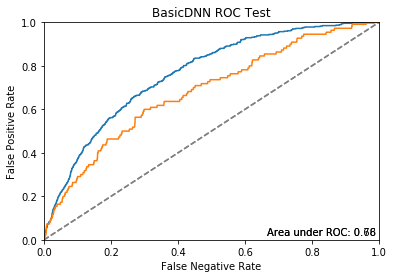

In [4]:
# Paths for all models
model_paths = []

# Header
print("-" * 75)
print("-" * 100)
print("\t\t\t\tFINAL MODEL COMPARISON")
print("-" * 100)
print("-" * 75, end="\n\n")

# Runs
for run_nr in range(n_runs):
    print("-" * 75)
    print("Run {}".format(run_nr))
    print("-" * 75, end="\n\n")

    ####
    # List of models
    n_batches = 2000

    # Models
    model_list = [
        LogisticRegressionSK(
            tensor_provider=the_tensor_provider,
            use_bow=True,
            use_embedsum=False,
            max_iter=300
        ),
        LogisticRegressionSK(
            tensor_provider=the_tensor_provider,
            use_bow=False,
            use_embedsum=True,
            max_iter=300
        ),
        LogisticRegressionSK(
            tensor_provider=the_tensor_provider,
            use_bow=True,
            use_embedsum=True,
            max_iter=300
        ),
        PULogisticRegressionSK(
            tensor_provider=the_tensor_provider,
            use_bow=True,
            use_embedsum=False
        ),
        PULogisticRegressionSK(
            tensor_provider=the_tensor_provider,
            use_bow=False,
            use_embedsum=True
        ),
        PULogisticRegressionSK(
            tensor_provider=the_tensor_provider,
            use_bow=True,
            use_embedsum=True
        ),
        BasicRecurrent(
            tensor_provider=the_tensor_provider,
            results_path=base_path,
            n_batches=n_batches,
            recurrent_units=50,
            feedforward_units=[200],
            dropouts=[1],
            dropout_rate=0.5,
            l2_weight_decay=1e-6,
            recurrent_neuron_type=tf.nn.rnn_cell.GRUCell,
            training_curve_y_limit=1000,
            learning_rate_progression=linear_geometric_curve(
                n=n_batches,
                starting_value=1e-4,
                end_value=1e-10,
                geometric_component=3. / 4,
                geometric_end=5
            ),
        ),
        BasicRecurrent(
            tensor_provider=the_tensor_provider,
            results_path=base_path,
            n_batches=n_batches,
            recurrent_units=400,
            feedforward_units=[50],
            dropouts=[1],
            dropout_rate=0.5,
            l2_weight_decay=1e-6,
            recurrent_neuron_type=tf.nn.rnn_cell.GRUCell,
            training_curve_y_limit=1000,
            learning_rate_progression=linear_geometric_curve(
                n=n_batches,
                starting_value=1e-4,
                end_value=1e-10,
                geometric_component=3. / 4,
                geometric_end=5
            ),
        ),
        BasicRecurrent(
            tensor_provider=the_tensor_provider,
            results_path=base_path,
            n_batches=n_batches,
            recurrent_units=400,
            feedforward_units=[200],
            dropouts=[1],
            dropout_rate=0.5,
            l2_weight_decay=1e-6,
            recurrent_neuron_type=tf.nn.rnn_cell.GRUCell,
            training_curve_y_limit=1000,
            learning_rate_progression=linear_geometric_curve(
                n=n_batches,
                starting_value=1e-4,
                end_value=1e-10,
                geometric_component=3. / 4,
                geometric_end=5
            ),
        ),
        BasicDNN(
            tensor_provider=the_tensor_provider,
            units=[150, 50],
            n_batches=n_batches,
            learning_rate_progression=linear_geometric_curve(
                n=n_batches,
                starting_value=1e-4,
                end_value=1e-10,
                geometric_component=3. / 4,
                geometric_end=5
            ),
            dropouts=[1, 2],
            dropout_rate=0.5,
            results_path=base_path
        ),
    ]

    ################

    for model_nr, a_model in enumerate(model_list):
        print("-" * 40)
        print("Model {}: {}\n".format(model_nr, a_model.name))

        # Run training on a single model
        single_training(
            tensor_provider=the_tensor_provider,
            model=a_model,
            test_split=list(test_programs),
            training_split=training_programs,
            base_path=base_path,
            access_restricted_data=True
        )
        model_paths.append(a_model.results_path)

print("\nModels created at paths:")
for path in model_paths:
    print("\t{}".format(path))

settings = dict(
    base_path=base_path,
    n_runs=n_runs,
    training_programs=training_programs,
    test_programs=test_programs,
)
pickle.dump(settings, Path(base_path, "settings.p").open("wb"))